# **Swarm Robotics Competitions**

### 2021/2022      

## A. Pedro Aguiar
<pedro.aguiar@fe.up.pt>
<br>

<br> FEUP Nov. 2021


---



**Initial setup:**
To run this notebook in *colab* you need to go to the colab pallete (left)-> file-> upload to session storage, and select the file **aux_file.py** that is in the same folder of this file.


# Swarm Marathon Competition


**Goal:** Collect a set of resources at positions $R_i$, $i=1, \ldots M$, and drop them at the warehouse (green border in the plot) within a fixed period of time $T$.

**Specifications:**
-  The fleet is composed by 5 drones.
- Drone 1 is the leader and has access to its global position $\xi_1$.
-  All the other drones *only* have access to the relative position $\xi_{ij}$ with respect to the other drones, if they are close enough to them (maximum range of MAX_RANGE).  
Example: Suppose that drone 1 and 3 are the only ones that are close to drone 2, then 
drone 2 has access to the relative position $\xi_{21}=\xi_2-\xi_1$ and $\xi_{23}=\xi_2-\xi_3$, and the others are set to zero $\xi_{24}=\xi_{25}=0$. 
- All drones have access to the closest distance and angle (direction) of the nearest obstacle, that is, $d_{io}$ and $\theta_{io}$.
- The maximum linear velocities (input) in $x$ and $y$ directions is $1\,m/s$, that is, $-1\le u_x, u_y \le 1$.
- The resources can only be picked and transported with two drones. Once they are carrying a resource, they cannot carry a second resource, and they should be no more than MAX_R_DIS apart of each other, otherwise it is considered that the resource is lost. 
- The drones cannot collide with each other, walls, and obstacles. In case of collision, the drone that collided stop and you do not have access to it. If it was transporting a resource, the resource returns to its initial position.

**Scores:**
- The times of picking the resources and dropping in the warehouse are saved. If the drones lost the resource, the time will be reseted.

- Wins the one that returned the maximum number of resources at the warehouse in less time.

**Parameters of this scenario:**
- Range of communication to obtain the relative position: MAX_RANGE = $5\,m$
- Maximum distance between 2 drones that they can be to pick a resource: MAX_R_PICK = $1\,m$
- Maximum distance between 2 drones that they can be to transport a resource: MAX_R_DIS = $3\,m$
- Initial configuration of the drones: 5-4-1-2-3 with same position in $y=-8\,m$ and in $x$ of $-2\,m, -1\,m, 0\,m, 1\,m, 2\,m$, respectively.
---



---
# **Scenario Task 3:** Two Resources $R_1$ and $R_2$ and two obstacles


You can include here the formulas used to compute $u_i$, $i=1, \ldots, 5$, that is
$$
u_1 = \ldots
$$ 

In [1]:
def my_swarm_control_law(t, R1, R2, R1_caught, R2_caught, R1_at_warehouse, R2_at_warehouse, \
                         d1o, angle1, d2o, angle2, d3o, angle3, d4o, angle4, d5o, angle5, \
                         state1, xi12, xi13, xi14, xi15, xi21, xi23, xi24, xi25, \
                         xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54):
###################################################################################################
##                                                                                               ##
##                                      Your code starts here                                    ##
##                                                                                               ##
## Grupo 5                                                                                       ##
## 201703919 João Araújo                                                                         ##
## 201305674 Daniel Santos                                                                       ##
## 201707097 João Silva                                                                          ##
## 202005277 André Sousa                                                                         ##
## 202007589 Tiago Ribeiro                                                                       ##
###################################################################################################
# Here goes the list of variables that you can use in this part: 
# time: t
# Resource positions: R1, R2
# Boolean variables that indicate if the Resource is with a pair of drones: R1_caught, R2_caught
# Boolean variables that indicate if the Resource was delivered at the warehouse: R1_at_warehouse, R2_at_warehouse
# distances and angles to the nearest obstacle: d1o, angle1, d2o, angle2, ...
# position of drone 1: state1
# relative positions: xi12, xi13, xi14, xi15, xi21, xi23, xi24, xi25, ...
# note that the relative positions are set to zero when its norm is bigger than MAX_RANGE
    
    # useful function to take norms
    #norm = np.linalg.norm
    def norm(vec):
        if not np.any(vec):
            return 1
        return np.linalg.norm(vec)
    
    # this shall stay here as a reminder of the facepalm when i realized that dynamically setting r2 to be the
    # leftmost (and r1 the rightmost) out of R1 and R2 can lead to some fun stuff, due to their positions changing
    r1 = np.array(R1)
    r2 = np.array(R2)
    r1_caught = R1_caught
    r2_caught = R2_caught
    r1_at_warehouse = R1_at_warehouse
    r2_at_warehouse = R2_at_warehouse
    
    lost = [0,False,not np.any(xi12),not np.any(xi12),not np.any(xi14),not np.any(xi14)]
    
    
    # obstacles
    dobs = [0, d1o, d2o, d3o, d4o, d5o]
    angs = [0, angle1, angle2, angle3, angle4, angle5]
    
    # calculates obstacle vector from the wall if it's indeed a wall
    perps = np.array([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
    def wall_vec(di):
        if min(abs(angs[di]-perps))<0.001:
            return np.array([np.cos(angs[di])*dobs[di],np.sin(angs[di])*dobs[di]])
        return np.zeros(2)
    
    # estimated position based on the wall
    def wall_pos(di):
        w=wall_vec(di)
        if w[0]<-0.001:
            return np.array([-10,0])-w
        if w[0]>0.001:
            return np.array([10,0])-w
        if w[1]<-0.001:
            return np.array([0,-10])-w
        if w[1]>0.001:
            return np.array([0,10])-w
        else:
            return np.zeros(2)
        
    # Assuming 5-4-1-2-3 (could generalize for any graph but there's really no need, since this function banks on walls
    # for faster movement and does fine on a variety of situations, as long as they're not too different from the original)
    pos = [0,state1,np.zeros(2),np.zeros(2),np.zeros(2),np.zeros(2)]
    pos[2]+= (pos[1]-xi12)*(not lost[2]) + wall_pos(2)*(lost[2])
    pos[3]+= (pos[2]-xi23)*(not lost[3]) + wall_pos(3)*(lost[3])
    pos[4]+= (pos[1]-xi14)*(not lost[4]) + wall_pos(4)*(lost[4])
    pos[5]+= (pos[4]-xi45)*(not lost[5]) + wall_pos(5)*(lost[5])
    
     
    # calculate goal vectors
    goal_vec = [0,np.zeros(2),np.zeros(2),np.zeros(2),np.zeros(2),np.zeros(2)]
    
    # drones 2 and 3
    if not r1_caught and not r1_at_warehouse:
        goal_vec[3] = r1-pos[3] + np.array([-1,0])*lost[3]*(t>15)*norm(r1-pos[3])
        goal_vec[2] = r1-pos[3] + np.array([-1,0])*lost[2]*(t>15)*norm(r1-pos[3])
        
    else:
        goal_vec[2] = np.array([-1,-1])
        goal_vec[3] = np.array([-1,-1])
    
    # drones 4 and 5
    if not r2_caught and not r2_at_warehouse:
        goal_vec[5] = r2-pos[5] + np.array([1,0])*lost[5]*(t>15)*norm(r2-pos[5])
        goal_vec[4] = r2-pos[5] + np.array([1,0])*lost[4]*(t>15)*norm(r2-pos[5])
        
    else:
        goal_vec[4] = np.array([-1,-1])
        goal_vec[5] = np.array([-1,-1])
    
    # drone 1 (leader) - could try to improve and generalize this but that's way too much of a hassle, and not worth it
    # assuming the scenario won't change too much in the competition
    goal_vec[1] = (not r1_caught)*((norm(xi12)>3.5)*(r1-pos[1]) + (norm(xi12)<=3.5)*(r2-pos[1])) + (r1_caught)*(r2-pos[1])
    if (r1_caught or r1_at_warehouse) and (r2_caught or r2_at_warehouse):
        if t<40:
            goal_vec[1] = np.array([1,1])
        else:
            goal_vec[1] = np.array([-1,-1])
    
    
    # avoid obstacles
    obs_vec = [0,0,0,0,0,0]
    for i in range(1,6):
        obs_vec[i] = np.array([dobs[i]*np.cos(angs[i]),dobs[i]*np.sin(angs[i])])
        
    # dodge other drones - initially, it just used appr_vec, but certain starting positions would then lead to crashes
    lsdr = [0,(xi21,xi31,xi41,xi51),(xi12,xi32,xi42,xi52),(xi13,xi23,xi43,xi53),(xi14,xi24,xi34,xi54),(xi15,xi25,xi35,xi45)]
    ddr_vec = [0,0,0,0,0,0]
    
    for i in range(1,6):
        ddr_vec[i] = sum([lsdr[i][j]*(norm(lsdr[i][j])<0.3)/norm(lsdr[i][j])**3/2 for j in range(4)])
    
    # approach partner drone
    appr_vec = [0,np.zeros(2),xi32,xi23,xi54,xi45]

    
    u_controls = [0,(0,0),(0,0),(0,0),(0,0),(0,0)]
    if not r1_at_warehouse or not r2_at_warehouse:
        for i in [1,3,5]:
            u_obs = -0.2*obs_vec[i]*(norm(obs_vec[i])<1)/norm(obs_vec[i])**3/2
            
            u_ddr = -0.2*ddr_vec[i]
            
            u_appr = 0.2*appr_vec[i]*(norm(appr_vec[i])>0.5)*norm(appr_vec[i])**3/2*(norm(goal_vec[i])>0.3)

            u_goal1 = goal_vec[i]/norm(goal_vec[i])*0.7
            u_goal2 = np.clip(goal_vec[i],-1,1)*0.3
            u_goal = (u_goal1+u_goal2)*(norm(goal_vec[i])>0.3)
            
            u_controls[i] = u_goal+u_obs+u_ddr+u_appr
            
            if np.any(u_controls[i]):
                u_controls[i]*= 1/max(abs(u_controls[i]))
                
            
        for i in [2,4]:
            u_obs = -0.2*obs_vec[i]*(norm(obs_vec[i])<0.3)/norm(obs_vec[i])**3/2
            
            u_ddr = -0.2*ddr_vec[i]
            
            u_appr = 0.5*appr_vec[i]*(norm(appr_vec[i])>0.3)*norm(appr_vec[i])**3/2

            u_goal = u_controls[i+1]/norm(u_controls[i+1])
            
            u_controls[i] = u_goal+u_obs+u_ddr+u_appr
            
            if np.any(u_controls[i]):
                u_controls[i]*= 1/max(abs(u_controls[i]))
                
    
    # u_controls
    u_control1, u_control2, u_control3, u_control4, u_control5 = u_controls[1:]
    
    
    return u_control1, u_control2, u_control3, u_control4, u_control5
###################################################################################################
##                                                                                               ##
##                              End of your code section, do not edit the next part              ##
##                                                                                               ##
###################################################################################################

In [23]:
##### RANDOM PARAMETERS #####

import math
import numpy as np
from aux_file import Integrator, Line, Ellipse, World, ConvexPolygon, check_collisions, update_relat_position, proximity, closest_drones, R_warehouse_check

# Parameters of range
MAX_RANGE = 5
MAX_R_PICK = 1
MAX_R_DIS = 3

# World arena
arena = ConvexPolygon([[ 10.0, -10.0 ],
                       [ 10.0, 10.0 ],
                       [ -10.0, 10.0 ],
                       [ -10.0, -10.0]])

#####
from numpy import random as rd
randseed = rd.randint(0,9999)
#randseed = 5440
#randseed = 958
#randseed = 760
#randseed = 2320
rd.seed(randseed)
#####

#####
# # World obstacles
# obs1 = Ellipse(center = [0.0, 0.0], angle = np.radians(15.0), axes = [4.0, 1.5])
# obs2 = Ellipse(center = [-4.0, 5.0], angle = np.radians(0.0), axes = [1.5, 1.5])


# # Resource
# initial_resource = {1: [7.5,5], 2: [-7.5,7.5]}
# resource = {1: [7.5,5], 2: [-7.5,7.5]}  # keep track of the positions of the resources
#####


#####
# World obstacles
obs1 = Ellipse(center = [0.0+rd.randn(), 0.0+rd.randn()], angle = np.radians(15.0+rd.randn()*9), 
               axes = [4.0+rd.randn()/2, 1.5+rd.randn()/2])
obs2 = Ellipse(center = [-4.0+rd.randn(), 5.0+rd.randn()], angle = np.radians(0.0+rd.randn()*9), 
               axes = [1.5+rd.randn()/2, 1.5+rd.randn()/2])

# Resource
tempr1,tempr2,tempr3,tempr4=rd.randn(4)
initial_resource = {1: [7.5+tempr1,5+tempr2], 2: [-7.5+tempr3,7.5+tempr4]}
resource = {1: [7.5+tempr1,5+tempr2], 2: [-7.5+tempr3,7.5+tempr4]}  # keep track of the positions of the resources
#####

num_R = 2
R1_caught = False
R2_caught = False

# Define world
world = World(arena)
world.add_obstacle(obs1)
world.add_obstacle(obs2)


#####
# # Drones 
# initial_state1 = [0.0, -8.0]
# initial_control1 = [0.0, 0.0]
# robot1 = Integrator(initial_state1, initial_control1)
# initial_state2 = [1.0, -8.0]
# initial_control2 = [0.0, 0.0]
# robot2 = Integrator(initial_state2, initial_control2)
# initial_state3 = [2.0, -8.0]
# initial_control3 = [0.0, 0.0]
# robot3 = Integrator(initial_state3, initial_control3)
# initial_state4 = [-1.0, -8.0]
# initial_control4 = [0.0, 0.0]
# robot4 = Integrator(initial_state4, initial_control4)
# initial_state5 = [-2.0, -8.0]
# initial_control5 = [0.0, 0.0]
# robot5 = Integrator(initial_state5, initial_control5)
#####


#####
#Drones 
initial_state1 = [0.0+rd.randn(), -8.0+rd.randn()]
initial_control1 = [0.0, 0.0]
robot1 = Integrator(initial_state1, initial_control1)
initial_state2 = [1.0+rd.randn(), -8.0+rd.randn()]
initial_control2 = [0.0, 0.0]
robot2 = Integrator(initial_state2, initial_control2)
initial_state3 = [2.0+rd.randn(), -8.0+rd.randn()]
initial_control3 = [0.0, 0.0]
robot3 = Integrator(initial_state3, initial_control3)
initial_state4 = [-1.0+rd.randn(), -8.0+rd.randn()]
initial_control4 = [0.0, 0.0]
robot4 = Integrator(initial_state4, initial_control4)
initial_state5 = [-2.0+rd.randn(), -8.0+rd.randn()]
initial_control5 = [0.0, 0.0]
robot5 = Integrator(initial_state5, initial_control5)
#####

# Time of simulation
sim_time = 60
dt = 0.1

time = []
ux1, uy1, ux2, uy2, ux3, uy3, ux4, uy4, ux5, uy5 = [], [], [], [], [], [], [], [], [], []
x1, y1, x2, y2, x3, y3, x4, y4, x5, y5  = [], [], [], [], [], [], [], [], [], []

#Closest point
cpx1, cpy1, cpx2, cpy2, cpx3, cpy3, cpx4, cpy4, cpx5, cpy5 = [], [], [], [], [], [], [], [], [], []

# Configuration Matrices 
do = np.zeros((5)) # Distance to obstacle
d_mtx = np.zeros((5)) # Damaged matrix
R_delivered = np.zeros((2)) # Indicates if Resource was delivered at the warehouse
w_R_mtx = np.zeros((5)) # Matrix that tells if a pair of drones caught some R
time_score = np.array([999.9,999.9,999.9,999.9]) # 0 - caught R_1, 1 - caught R_2, 2 - drop R_1 in warehouse, 3 - drop R_2 in warehouse
position_mtx = np.zeros((5,5)) # matrix that indicates which drones are near


# Here goes the main loop
for t in np.around(np.arange(int(sim_time/dt))*dt,2):

    # Time
    time.append(t)

    # Get the state
    state1 = robot1.get_state()
    state2 = robot2.get_state()
    state3 = robot3.get_state()
    state4 = robot4.get_state()
    state5 = robot5.get_state()
    
    # Relative positions
    xi12, xi13, xi14, xi15 = state1 - state2, state1 - state3, state1 - state4, state1 - state5
    xi21, xi23, xi24, xi25 = state2 - state1, state2 - state3, state2 - state4, state2 - state5
    xi31, xi32, xi34, xi35 = state3 - state1, state3 - state2, state3 - state4, state3 - state5
    xi41, xi42, xi43, xi45 = state4 - state1, state4 - state2, state4 - state3, state4 - state5
    xi51, xi52, xi53, xi54 = state5 - state1, state5 - state2, state5 - state3, state5 - state4
    #xi_all = (xi21, xi23, xi24, xi25, xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54)
    xi_all = (xi21, xi23, xi24, xi25, xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54, xi12, xi13, xi14, xi15)
    position_mtx, xi_all = update_relat_position(position_mtx, xi_all, MAX_RANGE)
    #xi21, xi23, xi24, xi25, xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54 = xi_all[0], xi_all[1], xi_all[2], xi_all[3], xi_all[4], xi_all[5], xi_all[6], xi_all[7], xi_all[8], xi_all[9], xi_all[10], xi_all[11], xi_all[12], xi_all[13], xi_all[14], xi_all[15]
    xi21, xi23, xi24, xi25, xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54, xi12, xi13, xi14, xi15 = xi_all[0], xi_all[1], xi_all[2], xi_all[3], xi_all[4], xi_all[5], xi_all[6], xi_all[7], xi_all[8], xi_all[9], xi_all[10], xi_all[11], xi_all[12], xi_all[13], xi_all[14], xi_all[15], xi_all[16], xi_all[17], xi_all[18], xi_all[19]
 
    # Get the closest point of obstacles of each drone
    closest_pt, do[0] = world.compute_closest(state1) 
    d1o = do[0]
    angle1 = np.arctan2(closest_pt[1]-state1[1],closest_pt[0]-state1[0])
    cpx1.append(closest_pt[0])
    cpy1.append(closest_pt[1])
    
    closest_pt, do[1] = world.compute_closest(state2) 
    d2o = do[1]
    angle2 = np.arctan2(closest_pt[1]-state2[1],closest_pt[0]-state2[0])
    cpx2.append(closest_pt[0])
    cpy2.append(closest_pt[1])
    
    closest_pt, do[2] = world.compute_closest(state3) 
    d3o = do[2]
    angle3 = np.arctan2(closest_pt[1]-state3[1],closest_pt[0]-state3[0])
    cpx3.append(closest_pt[0])
    cpy3.append(closest_pt[1])

    closest_pt, do[3] = world.compute_closest(state4) # closest point and distance to that point
    d4o = do[3]
    angle4 = np.arctan2(closest_pt[1]-state4[1],closest_pt[0]-state4[0])
    cpx4.append(closest_pt[0])
    cpy4.append(closest_pt[1])

    closest_pt, do[4] = world.compute_closest(state5) # closest point and distance to that point
    d5o = do[4]
    angle5 = np.arctan2(closest_pt[1]-state5[1],closest_pt[0]-state5[0])
    cpx5.append(closest_pt[0])
    cpy5.append(closest_pt[1])

    #Resources positions
    R1=resource[1]
    R2=resource[2]

    R1_at_warehouse = R_delivered[0]
    R2_at_warehouse = R_delivered[1]

    ######## Calling the control law for each drone
    u_control1, u_control2, u_control3, u_control4, u_control5 = my_swarm_control_law(t, R1, R2, R1_caught, R2_caught, R1_at_warehouse, R2_at_warehouse, \
                                                                                      d1o, angle1, d2o, angle2, d3o, angle3, d4o, angle4, d5o, angle5, \
                                                                                      state1, xi12, xi13, xi14, xi15, xi21, xi23, xi24, xi25, \
                                                                                      xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54)
    ########

    xi = (xi21, xi31, xi41, xi51)
    points_vec = np.array([state1,state2,state3,state4,state5])

    # Check collisions
    d_mtx, w_R_mtx, time_score = check_collisions(points_vec, d_mtx, w_R_mtx, do, xi, time_score)
    
    # compute a proximity table to check what are the drones that are closer to the Resources
    prox_mtx_1, prox_mtx_2 = proximity(points_vec, resource, num_R)

    # Send actuation commands
    if d_mtx[0]==1:
        u_control1=[0,0]
        u_control2=[0,0]
        u_control3=[0,0]
        u_control4=[0,0]
        u_control5=[0,0]
        prox_mtx_1[0] = 99
        prox_mtx_2[0] = 99    
        prox_mtx_1[1] = 99
        prox_mtx_2[1] = 99        
        prox_mtx_1[2] = 99
        prox_mtx_2[2] = 99        
        prox_mtx_1[3] = 99
        prox_mtx_2[3] = 99        
        prox_mtx_1[4] = 99
        prox_mtx_2[4] = 99        

    if d_mtx[1]==1:
        u_control2=[0,0]
        prox_mtx_1[1] = 99
        prox_mtx_2[1] = 99

    if d_mtx[2]==1:
        u_control3=[0,0]
        prox_mtx_1[2] = 99
        prox_mtx_2[2] = 99

    if d_mtx[3]==1:
        u_control4=[0,0]
        prox_mtx_1[3] = 99
        prox_mtx_2[3] = 99

    if d_mtx[4]==1:
        u_control5=[0,0]
        prox_mtx_1[4] = 99
        prox_mtx_2[4] = 99
    
    # Find the closest drones to the Resource
    w_R_mtx, time_score = closest_drones(prox_mtx_1, prox_mtx_2, w_R_mtx, time_score, t, R_delivered, num_R, MAX_R_PICK)

    if 1 in w_R_mtx:
        R1_caught = True
    else:
        R1_caught = False
    
    if 2 in w_R_mtx:
        R2_caught = True
    else:
        R2_caught = False
    
    # Saturate the control inputs between -1 and 1 
    u_control1 = np.clip(u_control1, -1, 1)
    u_control2 = np.clip(u_control2, -1, 1)
    u_control3 = np.clip(u_control3, -1, 1)
    u_control4 = np.clip(u_control4, -1, 1)
    u_control5 = np.clip(u_control5, -1, 1)

    robot1.set_control(u_control1)
    robot1.actuate(dt)
    robot2.set_control(u_control2)
    robot2.actuate(dt)
    robot3.set_control(u_control3)
    robot3.actuate(dt)
    robot4.set_control(u_control4)
    robot4.actuate(dt)
    robot5.set_control(u_control5)
    robot5.actuate(dt)    
    
    ux1.append(u_control1[0])
    uy1.append(u_control1[1])
    x1.append(state1[0])
    y1.append(state1[1])
    ux2.append(u_control2[0])
    uy2.append(u_control2[1])
    x2.append(state2[0])
    y2.append(state2[1])
    ux3.append(u_control3[0])
    uy3.append(u_control3[1])
    x3.append(state3[0])
    y3.append(state3[1])
    ux4.append(u_control4[0])
    uy4.append(u_control4[1])
    x4.append(state4[0])
    y4.append(state4[1])
    ux5.append(u_control5[0])
    uy5.append(u_control5[1])
    x5.append(state5[0])
    y5.append(state5[1])

    w_R_mtx, time_score, R_delivered = R_warehouse_check(w_R_mtx, points_vec, resource, time_score, t, R_delivered, MAX_R_DIS)
   

Drone 3 found the Resource 1
But no other drone found the Resource 1...
Drone 3 found the Resource 1
But no other drone found the Resource 1...
Drone 3 found the Resource 1
But no other drone found the Resource 1...
Drone 3 found the Resource 1
But no other drone found the Resource 1...
Drone 3 found the Resource 1
But no other drone found the Resource 1...
Drone 3 found the Resource 1
But no other drone found the Resource 1...
Drone 3 found the Resource 1
Drone 2 found the Resource 1
Drone 5 found the Resource 2
Drone 4 found the Resource 2
Resource 2 delivered!
Resource 1 delivered!


In [3]:
##### TASK 3 SETTINGS #####

import math
import numpy as np
from aux_file import Integrator, Line, Ellipse, World, ConvexPolygon, check_collisions, update_relat_position, proximity, closest_drones, R_warehouse_check

# Parameters of range
MAX_RANGE = 5
MAX_R_PICK = 1
MAX_R_DIS = 3

# World arena
arena = ConvexPolygon([[ 10.0, -10.0 ],
                       [ 10.0, 10.0 ],
                       [ -10.0, 10.0 ],
                       [ -10.0, -10.0]])

#####
from numpy import random as rd
# randseed = rd.randint(0,9999)
#randseed = 5440
#randseed = 958
#randseed = 760
# rd.seed(randseed)
#####

#####
# World obstacles
obs1 = Ellipse(center = [0.0, 0.0], angle = np.radians(15.0), axes = [4.0, 1.5])
obs2 = Ellipse(center = [-4.0, 5.0], angle = np.radians(0.0), axes = [1.5, 1.5])


# Resource
initial_resource = {1: [7.5,5], 2: [-7.5,7.5]}
resource = {1: [7.5,5], 2: [-7.5,7.5]}  # keep track of the positions of the resources
#####


#####
# # World obstacles
# obs1 = Ellipse(center = [0.0+rd.randn(), 0.0+rd.randn()], angle = np.radians(15.0+rd.randn()*9), 
#                axes = [4.0+rd.randn()/2, 1.5+rd.randn()/2])
# obs2 = Ellipse(center = [-4.0+rd.randn(), 5.0+rd.randn()], angle = np.radians(0.0+rd.randn()*9), 
#                axes = [1.5+rd.randn()/2, 1.5+rd.randn()/2])

# # Resource
# tempr1,tempr2,tempr3,tempr4=rd.randn(4)
# initial_resource = {1: [7.5+tempr1,5+tempr2], 2: [-7.5+tempr3,7.5+tempr4]}
# resource = {1: [7.5+tempr1,5+tempr2], 2: [-7.5+tempr3,7.5+tempr4]}  # keep track of the positions of the resources
#####

num_R = 2
R1_caught = False
R2_caught = False

# Define world
world = World(arena)
world.add_obstacle(obs1)
world.add_obstacle(obs2)


#####
# Drones 
initial_state1 = [0.0, -8.0]
initial_control1 = [0.0, 0.0]
robot1 = Integrator(initial_state1, initial_control1)
initial_state2 = [1.0, -8.0]
initial_control2 = [0.0, 0.0]
robot2 = Integrator(initial_state2, initial_control2)
initial_state3 = [2.0, -8.0]
initial_control3 = [0.0, 0.0]
robot3 = Integrator(initial_state3, initial_control3)
initial_state4 = [-1.0, -8.0]
initial_control4 = [0.0, 0.0]
robot4 = Integrator(initial_state4, initial_control4)
initial_state5 = [-2.0, -8.0]
initial_control5 = [0.0, 0.0]
robot5 = Integrator(initial_state5, initial_control5)
#####


#####
#Drones 
# initial_state1 = [0.0+rd.randn(), -8.0+rd.randn()]
# initial_control1 = [0.0, 0.0]
# robot1 = Integrator(initial_state1, initial_control1)
# initial_state2 = [1.0+rd.randn(), -8.0+rd.randn()]
# initial_control2 = [0.0, 0.0]
# robot2 = Integrator(initial_state2, initial_control2)
# initial_state3 = [2.0+rd.randn(), -8.0+rd.randn()]
# initial_control3 = [0.0, 0.0]
# robot3 = Integrator(initial_state3, initial_control3)
# initial_state4 = [-1.0+rd.randn(), -8.0+rd.randn()]
# initial_control4 = [0.0, 0.0]
# robot4 = Integrator(initial_state4, initial_control4)
# initial_state5 = [-2.0+rd.randn(), -8.0+rd.randn()]
# initial_control5 = [0.0, 0.0]
# robot5 = Integrator(initial_state5, initial_control5)
#####

# Time of simulation
sim_time = 60
dt = 0.1

time = []
ux1, uy1, ux2, uy2, ux3, uy3, ux4, uy4, ux5, uy5 = [], [], [], [], [], [], [], [], [], []
x1, y1, x2, y2, x3, y3, x4, y4, x5, y5  = [], [], [], [], [], [], [], [], [], []

#Closest point
cpx1, cpy1, cpx2, cpy2, cpx3, cpy3, cpx4, cpy4, cpx5, cpy5 = [], [], [], [], [], [], [], [], [], []

# Configuration Matrices 
do = np.zeros((5)) # Distance to obstacle
d_mtx = np.zeros((5)) # Damaged matrix
R_delivered = np.zeros((2)) # Indicates if Resource was delivered at the warehouse
w_R_mtx = np.zeros((5)) # Matrix that tells if a pair of drones caught some R
time_score = np.array([999.9,999.9,999.9,999.9]) # 0 - caught R_1, 1 - caught R_2, 2 - drop R_1 in warehouse, 3 - drop R_2 in warehouse
position_mtx = np.zeros((5,5)) # matrix that indicates which drones are near


# Here goes the main loop
for t in np.around(np.arange(int(sim_time/dt))*dt,2):

    # Time
    time.append(t)

    # Get the state
    state1 = robot1.get_state()
    state2 = robot2.get_state()
    state3 = robot3.get_state()
    state4 = robot4.get_state()
    state5 = robot5.get_state()
    
    # Relative positions
    xi12, xi13, xi14, xi15 = state1 - state2, state1 - state3, state1 - state4, state1 - state5
    xi21, xi23, xi24, xi25 = state2 - state1, state2 - state3, state2 - state4, state2 - state5
    xi31, xi32, xi34, xi35 = state3 - state1, state3 - state2, state3 - state4, state3 - state5
    xi41, xi42, xi43, xi45 = state4 - state1, state4 - state2, state4 - state3, state4 - state5
    xi51, xi52, xi53, xi54 = state5 - state1, state5 - state2, state5 - state3, state5 - state4
    #xi_all = (xi21, xi23, xi24, xi25, xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54)
    xi_all = (xi21, xi23, xi24, xi25, xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54, xi12, xi13, xi14, xi15)
    position_mtx, xi_all = update_relat_position(position_mtx, xi_all, MAX_RANGE)
    #xi21, xi23, xi24, xi25, xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54 = xi_all[0], xi_all[1], xi_all[2], xi_all[3], xi_all[4], xi_all[5], xi_all[6], xi_all[7], xi_all[8], xi_all[9], xi_all[10], xi_all[11], xi_all[12], xi_all[13], xi_all[14], xi_all[15]
    xi21, xi23, xi24, xi25, xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54, xi12, xi13, xi14, xi15 = xi_all[0], xi_all[1], xi_all[2], xi_all[3], xi_all[4], xi_all[5], xi_all[6], xi_all[7], xi_all[8], xi_all[9], xi_all[10], xi_all[11], xi_all[12], xi_all[13], xi_all[14], xi_all[15], xi_all[16], xi_all[17], xi_all[18], xi_all[19]
 
    # Get the closest point of obstacles of each drone
    closest_pt, do[0] = world.compute_closest(state1) 
    d1o = do[0]
    angle1 = np.arctan2(closest_pt[1]-state1[1],closest_pt[0]-state1[0])
    cpx1.append(closest_pt[0])
    cpy1.append(closest_pt[1])
    
    closest_pt, do[1] = world.compute_closest(state2) 
    d2o = do[1]
    angle2 = np.arctan2(closest_pt[1]-state2[1],closest_pt[0]-state2[0])
    cpx2.append(closest_pt[0])
    cpy2.append(closest_pt[1])
    
    closest_pt, do[2] = world.compute_closest(state3) 
    d3o = do[2]
    angle3 = np.arctan2(closest_pt[1]-state3[1],closest_pt[0]-state3[0])
    cpx3.append(closest_pt[0])
    cpy3.append(closest_pt[1])

    closest_pt, do[3] = world.compute_closest(state4) # closest point and distance to that point
    d4o = do[3]
    angle4 = np.arctan2(closest_pt[1]-state4[1],closest_pt[0]-state4[0])
    cpx4.append(closest_pt[0])
    cpy4.append(closest_pt[1])

    closest_pt, do[4] = world.compute_closest(state5) # closest point and distance to that point
    d5o = do[4]
    angle5 = np.arctan2(closest_pt[1]-state5[1],closest_pt[0]-state5[0])
    cpx5.append(closest_pt[0])
    cpy5.append(closest_pt[1])

    #Resources positions
    R1=resource[1]
    R2=resource[2]

    R1_at_warehouse = R_delivered[0]
    R2_at_warehouse = R_delivered[1]

    ######## Calling the control law for each drone
    u_control1, u_control2, u_control3, u_control4, u_control5 = my_swarm_control_law(t, R1, R2, R1_caught, R2_caught, R1_at_warehouse, R2_at_warehouse, \
                                                                                      d1o, angle1, d2o, angle2, d3o, angle3, d4o, angle4, d5o, angle5, \
                                                                                      state1, xi12, xi13, xi14, xi15, xi21, xi23, xi24, xi25, \
                                                                                      xi31, xi32, xi34, xi35, xi41, xi42, xi43, xi45, xi51, xi52, xi53, xi54)
    ########

    xi = (xi21, xi31, xi41, xi51)
    points_vec = np.array([state1,state2,state3,state4,state5])

    # Check collisions
    d_mtx, w_R_mtx, time_score = check_collisions(points_vec, d_mtx, w_R_mtx, do, xi, time_score)
    
    # compute a proximity table to check what are the drones that are closer to the Resources
    prox_mtx_1, prox_mtx_2 = proximity(points_vec, resource, num_R)

    # Send actuation commands
    if d_mtx[0]==1:
        u_control1=[0,0]
        u_control2=[0,0]
        u_control3=[0,0]
        u_control4=[0,0]
        u_control5=[0,0]
        prox_mtx_1[0] = 99
        prox_mtx_2[0] = 99    
        prox_mtx_1[1] = 99
        prox_mtx_2[1] = 99        
        prox_mtx_1[2] = 99
        prox_mtx_2[2] = 99        
        prox_mtx_1[3] = 99
        prox_mtx_2[3] = 99        
        prox_mtx_1[4] = 99
        prox_mtx_2[4] = 99        

    if d_mtx[1]==1:
        u_control2=[0,0]
        prox_mtx_1[1] = 99
        prox_mtx_2[1] = 99

    if d_mtx[2]==1:
        u_control3=[0,0]
        prox_mtx_1[2] = 99
        prox_mtx_2[2] = 99

    if d_mtx[3]==1:
        u_control4=[0,0]
        prox_mtx_1[3] = 99
        prox_mtx_2[3] = 99

    if d_mtx[4]==1:
        u_control5=[0,0]
        prox_mtx_1[4] = 99
        prox_mtx_2[4] = 99
    
    # Find the closest drones to the Resource
    w_R_mtx, time_score = closest_drones(prox_mtx_1, prox_mtx_2, w_R_mtx, time_score, t, R_delivered, num_R, MAX_R_PICK)

    if 1 in w_R_mtx:
        R1_caught = True
    else:
        R1_caught = False
    
    if 2 in w_R_mtx:
        R2_caught = True
    else:
        R2_caught = False
    
    # Saturate the control inputs between -1 and 1 
    u_control1 = np.clip(u_control1, -1, 1)
    u_control2 = np.clip(u_control2, -1, 1)
    u_control3 = np.clip(u_control3, -1, 1)
    u_control4 = np.clip(u_control4, -1, 1)
    u_control5 = np.clip(u_control5, -1, 1)

    robot1.set_control(u_control1)
    robot1.actuate(dt)
    robot2.set_control(u_control2)
    robot2.actuate(dt)
    robot3.set_control(u_control3)
    robot3.actuate(dt)
    robot4.set_control(u_control4)
    robot4.actuate(dt)
    robot5.set_control(u_control5)
    robot5.actuate(dt)    
    
    ux1.append(u_control1[0])
    uy1.append(u_control1[1])
    x1.append(state1[0])
    y1.append(state1[1])
    ux2.append(u_control2[0])
    uy2.append(u_control2[1])
    x2.append(state2[0])
    y2.append(state2[1])
    ux3.append(u_control3[0])
    uy3.append(u_control3[1])
    x3.append(state3[0])
    y3.append(state3[1])
    ux4.append(u_control4[0])
    uy4.append(u_control4[1])
    x4.append(state4[0])
    y4.append(state4[1])
    ux5.append(u_control5[0])
    uy5.append(u_control5[1])
    x5.append(state5[0])
    y5.append(state5[1])

    w_R_mtx, time_score, R_delivered = R_warehouse_check(w_R_mtx, points_vec, resource, time_score, t, R_delivered, MAX_R_DIS)
   

Drone 3 found the Resource 1
But no other drone found the Resource 1...
Drone 3 found the Resource 1
Drone 2 found the Resource 1
Drone 5 found the Resource 2
Drone 4 found the Resource 2
Resource 1 delivered!
Resource 2 delivered!


Random Seed:  8802
Ellipse 1 ->  center:  [-1.00791499  0.29879761] angle:  -0.013407808612375007 axes:  [4.36953084 1.39326108]
Ellipse 2 ->  center:  [-4.63446558  5.15796235] angle:  -0.03156080808335295 axes:  [1.39468326 0.73515421]
Initial Resource Positions:  
R1:  [9.350920312061012, 6.540921749530534] 
R2:  [-6.880890351675168, 6.623959678533569]
Initial Drone Positions:  
state1:  [-0.9550648228015114, -8.188285499747613] 
state2:  [0.2856203068417398, -8.747710321436491] 
state3:  [0.5924517007748922, -8.281741199498589] 
state4:  [0.23655199501646362, -6.6326258307721675] 
state5:  [-1.5678330388547272, -7.229127986616118] 

Results:
Time of picking Resource 1: 14.5
Time of picking resource 2: 14.7
Time of delivering Resource 1 at the warehouse: 31.0
Time of delivering Resource 2 at the warehouse: 26.7
Final score: 31.0


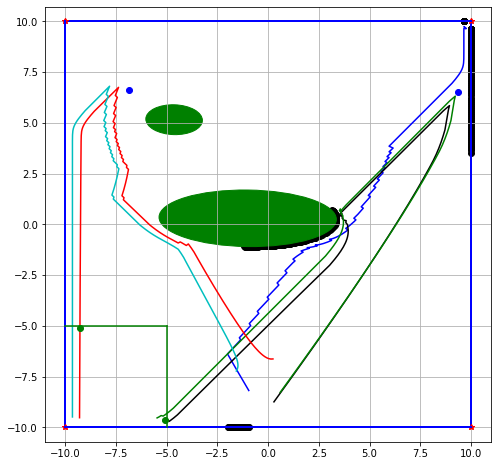

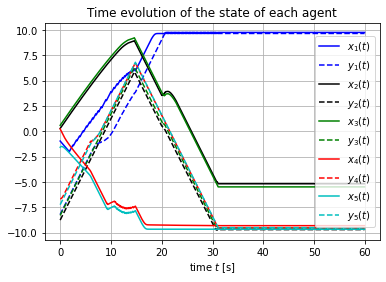

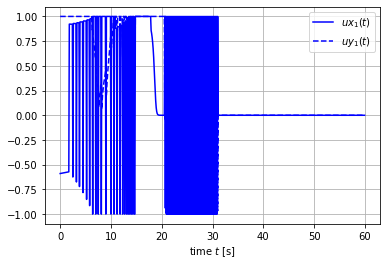

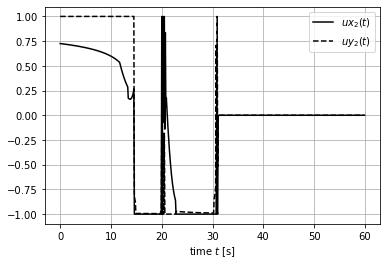

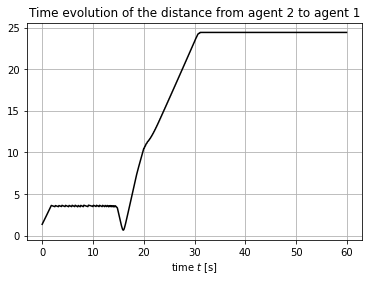

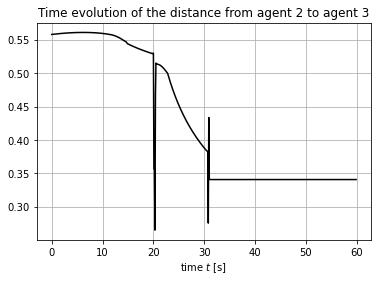

In [24]:
print('Random Seed: ',randseed)
print('Ellipse 1 -> ', 'center: ',obs1.center, 'angle: ',obs1.angle, 'axes: ', obs1.axes)
print('Ellipse 2 -> ', 'center: ',obs2.center, 'angle: ',obs2.angle, 'axes: ', obs2.axes)
print('Initial Resource Positions: ', '\nR1: ', initial_resource.get(1), '\nR2: ', initial_resource.get(2))
print('Initial Drone Positions: ', '\nstate1: ',initial_state1,'\nstate2: ',initial_state2,'\nstate3: ',initial_state3,
      '\nstate4: ',initial_state4,'\nstate5: ',initial_state5,'\n')

# Plot commands
%matplotlib inline 
#%matplotlib notebook

import matplotlib.pyplot as plt

#fig, ax = plt.subplots(figsize=(18,18))
fig, ax = plt.subplots(figsize=(8,8))

#plt.figure(figsize=(1,1))
ax.axis('equal')
xdim, ydim = 10, 10
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.grid()

# Plots walls and obstacles
world.plot()

line1, = plt.plot(x1, y1, label='$x_1(t), y_1(t)$', color='b')
points_lidar = plt.scatter(cpx1, cpy1, label='$cpx_1(t), cpy_1(t)$', marker='o', color='k')
line2, = plt.plot(x2, y2, label='$x_2(t), y_2(t)$', color='k')
line3, = plt.plot(x3, y3, label='$x_3(t), y_3(t)$', color='g')
line4, = plt.plot(x4, y4, label='$x_4(t), y_4(t)$', color='r')
line5, = plt.plot(x5, y5, label='$x_5(t), y_5(t)$', color='c')
plt.plot((-10,-5),(-5,-5), color='g')
plt.plot((-5,-5),(-5,-10), color='g')

if R_delivered[0] == False:
    initial_resource1, = plt.plot(initial_resource[1][0], initial_resource[1][1], marker='o', color='r')
else:
    initial_resource1, = plt.plot(initial_resource[1][0], initial_resource[1][1], marker='o', color='b')
    final_resource1, = plt.plot(resource[1][0], resource[1][1], marker='o', color='g')

if num_R == 2:
    if R_delivered[1] == False:
        initial_resource2, = plt.plot(initial_resource[2][0], initial_resource[2][1], marker='o', color='r')
    else:
        initial_resource2, = plt.plot(initial_resource[2][0], initial_resource[2][1], marker='o', color='b')
        final_resource2, = plt.plot(resource[2][0], resource[2][1], marker='o', color='g')


if d_mtx[0] == 1:
    plt.plot(state1[0], state1[1], marker='*', color='y')
if d_mtx[1] == 1:
    plt.plot(state2[0], state2[1], marker='*', color='y')
if d_mtx[2] == 1:
    plt.plot(state3[0], state3[1], marker='*', color='y')
if d_mtx[3] == 1:
    plt.plot(state4[0], state4[1], marker='*', color='y')
if d_mtx[4] == 1:
    plt.plot(state5[0], state5[1], marker='*', color='y')


plt.figure()
plt.plot(time, x1, label='$x_1(t)$', color='b')
plt.plot(time, y1, label='$y_1(t)$', color='b', linestyle='dashed')
plt.plot(time, x2, label='$x_2(t)$', color='k')
plt.plot(time, y2, label='$y_2(t)$', color='k', linestyle='dashed')
plt.plot(time, x3, label='$x_3(t)$', color='g')
plt.plot(time, y3, label='$y_3(t)$', color='g', linestyle='dashed')
plt.plot(time, x4, label='$x_4(t)$', color='r')
plt.plot(time, y4, label='$y_4(t)$', color='r', linestyle='dashed')
plt.plot(time, x5, label='$x_5(t)$', color='c')
plt.plot(time, y5, label='$y_5(t)$', color='c', linestyle='dashed')
plt.xlabel('time $t$ [s]')
plt.legend()
plt.grid()
plt.title('Time evolution of the state of each agent');


plt.figure()
plt.plot(time, ux1, label='$ux_1(t)$', color='b')
plt.plot(time, uy1, label='$uy_1(t)$', color='b', linestyle='dashed')
plt.xlabel('time $t$ [s]')
plt.legend()
plt.grid()
plt.figure()
plt.plot(time, ux2, label='$ux_2(t)$', color='k')
plt.plot(time, uy2, label='$uy_2(t)$', color='k', linestyle='dashed')
plt.xlabel('time $t$ [s]')
plt.legend()
plt.grid()

plt.figure()
dist21=zip(x1,y1,x2,y2)
dist21 = [np.sqrt((x1-x2)**2+(y1-y2)**2) for (x1,y1,x2,y2) in dist21]
plt.plot(time, dist21, label='$x_1-x_2$', color='k')
plt.grid()
plt.title('Time evolution of the distance from agent 2 to agent 1');
plt.xlabel('time $t$ [s]');

plt.figure()
dist23=zip(x2,y2,x3,y3)
dist23 = [np.sqrt((x2-x3)**2+(y2-y3)**2) for (x2,y2,x3,y3) in dist23]
plt.plot(time, dist23, label='$x_2-x_3$', color='k')
plt.grid()
plt.title('Time evolution of the distance from agent 2 to agent 3');
plt.xlabel('time $t$ [s]');

print("Results:")
#time_score: 0 - caught R_1, 1 - caught R_2, 2 - drop R_1 in warehouse, 3 - drop R_2 in warehouse
print('Time of picking Resource 1:',time_score[0])
print('Time of picking resource 2:',time_score[1])
print('Time of delivering Resource 1 at the warehouse:',time_score[2])
print('Time of delivering Resource 2 at the warehouse:',time_score[3])
print('Final score:',max(time_score[2],time_score[3]))



In [12]:
from matplotlib import animation

fnum = len(x1)
#print(fnum)
# animation function. This is called sequentially
def drawframe(n):
    #print(n)
    #print('time:',time_score[0])
    if time_score[2]!=999.9:
        if n < time_score[0]*10:
            initial_resource1.set_data(initial_resource[1][0], initial_resource[1][1])
            initial_resource1.set_color('r')
        else: 
            initial_resource1.set_color('b')
    if time_score[2]!=999.9:
        if n < time_score[1]*10:
            initial_resource2.set_data(initial_resource[2][0], initial_resource[2][1])
            initial_resource2.set_color('r')
        else: 
            initial_resource2.set_color('b')
    
    if time_score[2]!=999.9:
        if n < time_score[2]*10:
            final_resource1.set_data(resource[1][0], resource[1][1])
            final_resource1.set_color("w")
            final_resource1.set_alpha(0.0)
        else:
            final_resource1.set_data(resource[1][0], resource[1][1])
            final_resource1.set_color("g")
            final_resource1.set_alpha(1.0)
    
    if time_score[2]!=999.9:
        if n < time_score[3]*10:
            final_resource2.set_data(resource[2][0], resource[2][1])
            final_resource2.set_color("w")
            final_resource2.set_alpha(0.0)
        else:
            final_resource2.set_data(resource[2][0], resource[2][1])
            final_resource2.set_color("g")
            final_resource2.set_alpha(1.0)
    
    line1.set_data(x1[0:n], y1[0:n])
    line2.set_data(x2[0:n], y2[0:n])
    line3.set_data(x3[0:n], y3[0:n])
    line4.set_data(x4[0:n], y4[0:n])
    line5.set_data(x5[0:n], y5[0:n])
    points_lidar.set_offsets(np.c_[cpx1[0:n], cpy1[0:n]])
    return (line1,line2)


# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=fnum, interval=15, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### done (seems to work) ### make sure repulsion is working properly and extend it to all 5 drones

### kinda done ### consider fixing the links thing - maybe drone 1 follows 5 if distance to 3 is smaller than 4 and follows 3 otherwise (assuming not R1_caught)

### almost pointless since walls are op ### complete graph thing to determine positions or if it's lost

### done ... NVM ### leftmost food -> drones 4 and 5, rightmost food -> drones 2 and 3 ... NVM!!! not worth it!

### pointless ### statistical approach by throwing dots randomly outside the areas with home, drone obstacle free circles and maybe obstacle approx

### probably suboptimal ### stretched out links and get lost when position is right to contract

### done ### if food is caught, then goal_vec becomes (-1,-1)

### kinda done ### improve extraction points

### done ### if lost: if it detects a wall, it tries to be at the correct distance to catch the food

### done ### check task 0 - drones 4 and 5 crash into each other

### done ### check task 1 - drone 3 takes the long route vs the obstacle

### done ### make it so for each pair, one of them decides the vecs and the other just follows (5 is leftmost and 3 is rightmost leader)

### done ### fix double route issue - first calculate 3 and 5 all the way, then use the controls for the 2 and 4 goals

### done (seems fine) ### fix drone 1 pathing

### kinda done before i started...? ### improve escorting behavior of drone 1 - current behavior is good for most cases where you don't change it up too much and it's way too much of a hassle to generalize it without harming current performance

### done ### add some function of time dealio to handle the harder cases, for instance when you need to go the other way

### done (forgot to disable u_approx when near the goal) ### figure out why the hell the drones sometimes stop where it really seems like they shouldn't

### done ### fix issue with the drones swapping target - fixed by undoing the leftmost/rightmost food thing


# best time so far (with the same parameters as the original) -> 26.4